In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
import ast
import os
import csv

In [3]:
# Read data from output_data_filled.csv
data = pd.read_csv('data_raw/output_data_filled.csv')

In [4]:
# Lấy danh sách các đội từ cột home_team và away_team
home_teams = data['home_team'].unique()
away_teams = data['away_team'].unique()

# Kết hợp danh sách các đội và loại bỏ các giá trị trùng lặp
all_teams = set(home_teams).union(set(away_teams))

# Chuyển đổi thành DataFrame
teams_df = pd.DataFrame(list(all_teams), columns=['Team'])

# Lưu vào tệp CSV
teams_df.to_csv('data_raw/unique_teams.csv', index=False)

In [5]:
# Đọc dữ liệu từ tệp CSV
teams_df = pd.read_csv('data_raw/unique_teams.csv')

# Sắp xếp theo tên đội
teams_df = teams_df.sort_values('Team')

# Chuyển đổi thành danh sách
teams = teams_df['Team'].tolist()

# Create a dropdown menu for selecting a team
team_selector = widgets.Dropdown(
    options=teams,
    description='Select Team:',
    disabled=False,
)

# Function to update the analysis based on the selected team
def update_analysis(team):
    # Filter matches for the selected team
    matches_home = data[data['home_team'] == team]
    matches_away = data[data['away_team'] == team]
    
    # Keep necessary columns
    necessary_columns = ['year', 'home_team', 'away_team', 'score']
    matches_home = matches_home[necessary_columns]
    matches_away = matches_away[necessary_columns]
    
    # Count the number of wins per year
    wins_per_year_home = matches_home[matches_home['score'].apply(lambda x: int(x.split(':')[0]) > int(x.split(':')[1]))].groupby('year').size()
    wins_per_year_away = matches_away[matches_away['score'].apply(lambda x: int(x.split(':')[0]) < int(x.split(':')[1]))].groupby('year').size()
    
    # Combine home and away wins
    wins_per_year = wins_per_year_home.add(wins_per_year_away, fill_value=0)
    
    # Calculate the total number of matches per year
    total_matches_per_year = matches_home['year'].value_counts().add(matches_away['year'].value_counts(), fill_value=0).sort_index()
    
    # Calculate the win rate per year
    win_rate_per_year = (wins_per_year / total_matches_per_year) * 100
    
    # Plot the win rate, number of wins, and goals per year
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.bar(wins_per_year.index, wins_per_year, color='b', alpha=0.6, label='Number of Wins')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Wins', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(win_rate_per_year.index, win_rate_per_year, color='r', marker='o', label='Win Rate')
    ax2.set_ylabel('Win Rate (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    fig.tight_layout()
    plt.title(f'Analysis per Year by {team}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.show()

# Display the dropdown menu and set up the event handler
widgets.interactive(update_analysis, team=team_selector)


interactive(children=(Dropdown(description='Select Team:', options=('AFC Bournemouth', 'Arsenal FC', 'Aston Vi…

In [6]:
# Function to update the analysis based on the selected team
def update_analysis(team):
    # Filter matches for the selected team
    matches_home = data[data['home_team'] == team]
    matches_away = data[data['away_team'] == team]
    
    # Keep necessary columns
    necessary_columns = ['year', 'home_team', 'away_team', 'score']
    matches_home = matches_home[necessary_columns]
    matches_away = matches_away[necessary_columns]
    
    # Calculate the number of goals per year
    goals_home = matches_home['score'].apply(lambda x: int(x.split(':')[0])).groupby(matches_home['year']).sum()
    goals_away = matches_away['score'].apply(lambda x: int(x.split(':')[1])).groupby(matches_away['year']).sum()
    goals_per_year = goals_home.add(goals_away, fill_value=0)
    
    # Calculate the number of goals per match per year
    total_matches_per_year = matches_home['year'].value_counts().add(matches_away['year'].value_counts(), fill_value=0).sort_index()
    goals_per_match_per_year = goals_per_year / total_matches_per_year
    
    # Plot the number of goals per year and goals per match per year
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.bar(goals_per_year.index, goals_per_year, color='g', alpha=0.6, label='Number of Goals')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Goals', color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    
    ax2 = ax1.twinx()
    ax2.plot(goals_per_match_per_year.index, goals_per_match_per_year, color='m', marker='o', label='Goals per Match')
    ax2.set_ylabel('Goals per Match', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
    
    fig.tight_layout()
    plt.title(f'Goals Analysis per Year by {team}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.show()

# Display the dropdown menu and set up the event handler
widgets.interactive(update_analysis, team=team_selector)


interactive(children=(Dropdown(description='Select Team:', options=('AFC Bournemouth', 'Arsenal FC', 'Aston Vi…

In [7]:
# Function to update the performance analysis based on the selected team
def update_performance_analysis(team):
    # Filter matches for the selected team
    matches_home = data[data['home_team'] == team]
    matches_away = data[data['away_team'] == team]
    
    # Keep necessary columns
    necessary_columns = ['year', 'home_team', 'away_team', 'score']
    matches_home = matches_home[necessary_columns]
    matches_away = matches_away[necessary_columns]
    
    # Calculate the performance as home and away team
    home_wins = matches_home[matches_home['score'].apply(lambda x: int(x.split(':')[0]) > int(x.split(':')[1]))].shape[0]
    away_wins = matches_away[matches_away['score'].apply(lambda x: int(x.split(':')[0]) < int(x.split(':')[1]))].shape[0]
    home_draws = matches_home[matches_home['score'].apply(lambda x: int(x.split(':')[0]) == int(x.split(':')[1]))].shape[0]
    away_draws = matches_away[matches_away['score'].apply(lambda x: int(x.split(':')[0]) == int(x.split(':')[1]))].shape[0]
    home_losses = matches_home[matches_home['score'].apply(lambda x: int(x.split(':')[0]) < int(x.split(':')[1]))].shape[0]
    away_losses = matches_away[matches_away['score'].apply(lambda x: int(x.split(':')[0]) > int(x.split(':')[1]))].shape[0]
    
    # Define colors
    colors = ['#ff9999', '#66b3ff']
    
    # Plot the pie charts
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Wins pie chart
    sizes = [home_wins, away_wins]
    axs[0].pie(sizes, colors=colors, autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)} games)', startangle=90)
    axs[0].axis('equal')
    axs[0].set_title('Wins')
    
    # Draws pie chart
    sizes = [home_draws, away_draws]
    axs[1].pie(sizes, colors=colors, autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)} games)', startangle=90)
    axs[1].axis('equal')
    axs[1].set_title('Draws')
    
    # Losses pie chart
    sizes = [home_losses, away_losses]
    axs[2].pie(sizes, colors=colors, autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)} games)', startangle=90)
    axs[2].axis('equal')
    axs[2].set_title('Losses')
    
    # Add a common legend
    fig.legend(['Home', 'Away'], loc='lower center', ncol=2)
    
    plt.suptitle(f'Performance of {team} as Home and Away Team')
    plt.show()

# Display the dropdown menu and set up the event handler
widgets.interactive(update_performance_analysis, team=team_selector)


interactive(children=(Dropdown(description='Select Team:', options=('AFC Bournemouth', 'Arsenal FC', 'Aston Vi…

In [8]:
# Hàm lấy dữ liệu đội bóng
def get_team_stats(team):
    matches_home = data[data['home_team'] == team]
    matches_away = data[data['away_team'] == team]
    
    necessary_columns = ['year', 'home_team', 'away_team', 'stat', 'score']
    matches_home = matches_home[necessary_columns]
    matches_away = matches_away[necessary_columns]
    
    def extract_stat(stat, index, position):
        try:
            values = ast.literal_eval(stat)
            return values[index].split()[position]
        except (IndexError, ValueError):
            return None
    
    stats_columns = ['total_shots', 'shots_off_target', 'shots_saved', 'corners', 'free_kicks', 'fouls', 'offsides']
    for i, col in enumerate(stats_columns, start=1):
        matches_home[col] = matches_home['stat'].apply(lambda x: extract_stat(x, i, 0))
        matches_away[col] = matches_away['stat'].apply(lambda x: extract_stat(x, i, 1))

    matches = pd.concat([matches_home, matches_away])
    
    # Calculate goals per match
    goals_home = matches[matches['home_team'] == team]['score'].apply(lambda x: int(x.split(':')[0])).sum()
    goals_away = matches[matches['away_team'] == team]['score'].apply(lambda x: int(x.split(':')[1])).sum()
    total_matches = matches.shape[0]
    goals_per_match = (goals_home + goals_away) / total_matches if total_matches > 0 else 0
    
    return matches[stats_columns].astype(float).mean(), goals_per_match

# Tính toán mean cho tất cả các đội
team_means = {}
goals_per_match_dict = {}
for team in teams:
    team_means[team], goals_per_match_dict[team] = get_team_stats(team)

# Chuyển đổi sang DataFrame để dễ dàng phân tích
team_means_df = pd.DataFrame(team_means).T

# Tìm mean cao nhất và thấp nhất cho mỗi chỉ số
highest_means = team_means_df.idxmax()
lowest_means = team_means_df.idxmin()
highest_values = team_means_df.max()
lowest_values = team_means_df.min()

# Tìm đội có giá trị goals_per_match cao nhất và thấp nhất
highest_goals_per_match_team = max(goals_per_match_dict, key=goals_per_match_dict.get)
highest_goals_per_match_value = goals_per_match_dict[highest_goals_per_match_team]

lowest_goals_per_match_team = min(goals_per_match_dict, key=goals_per_match_dict.get)
lowest_goals_per_match_value = goals_per_match_dict[lowest_goals_per_match_team]

# In ra kết quả
print("Highest Mean Values:")
for stat, team in highest_means.items():
    print(f"{stat}: {highest_values[stat]} (Team: {team})")
print(f"goals_per_match: {highest_goals_per_match_value} (Team: {highest_goals_per_match_team})")

print("\nLowest Mean Values:")
for stat, team in lowest_means.items():
    print(f"{stat}: {lowest_values[stat]} (Team: {team})")
print(f"goals_per_match: {lowest_goals_per_match_value} (Team: {lowest_goals_per_match_team})")

# Save the results to a CSV file
results = pd.DataFrame({
    'Highest Mean Values': highest_means,
    'Highest Values': highest_values,
    'Lowest Mean Values': lowest_means,
    'Lowest Values': lowest_values
})

# Add the goals per match information as rows
results.loc['goals_per_match'] = [
    highest_goals_per_match_team,
    highest_goals_per_match_value,
    lowest_goals_per_match_team,
    lowest_goals_per_match_value
]

results.to_csv('data_raw/team_stats_results.csv')


Highest Mean Values:
total_shots: 12.854545454545455 (Team: Leeds United)
shots_off_target: 5.947222222222222 (Team: Manchester City)
shots_saved: 4.482142857142857 (Team: Sunderland AFC)
corners: 7.311111111111111 (Team: Manchester City)
free_kicks: 13.342857142857143 (Team: Queens Park Rangers)
fouls: 12.421052631578947 (Team: Middlesbrough FC)
offsides: 2.3054545454545456 (Team: Burnley FC)
goals_per_match: 2.386243386243386 (Team: Manchester City)

Lowest Mean Values:
total_shots: 2.6315789473684212 (Team: Middlesbrough FC)
shots_off_target: 3.443298969072165 (Team: Sheffield United)
shots_saved: 1.8694444444444445 (Team: Manchester City)
corners: 3.710526315789474 (Team: Middlesbrough FC)
free_kicks: 8.257731958762887 (Team: Sheffield United)
fouls: 9.380555555555556 (Team: Manchester City)
offsides: 1.1842105263157894 (Team: Middlesbrough FC)
goals_per_match: 0.6578947368421053 (Team: Huddersfield Town)


interactive(children=(Dropdown(description='Select Team:', options=('AFC Bournemouth', 'Arsenal FC', 'Aston Vi…

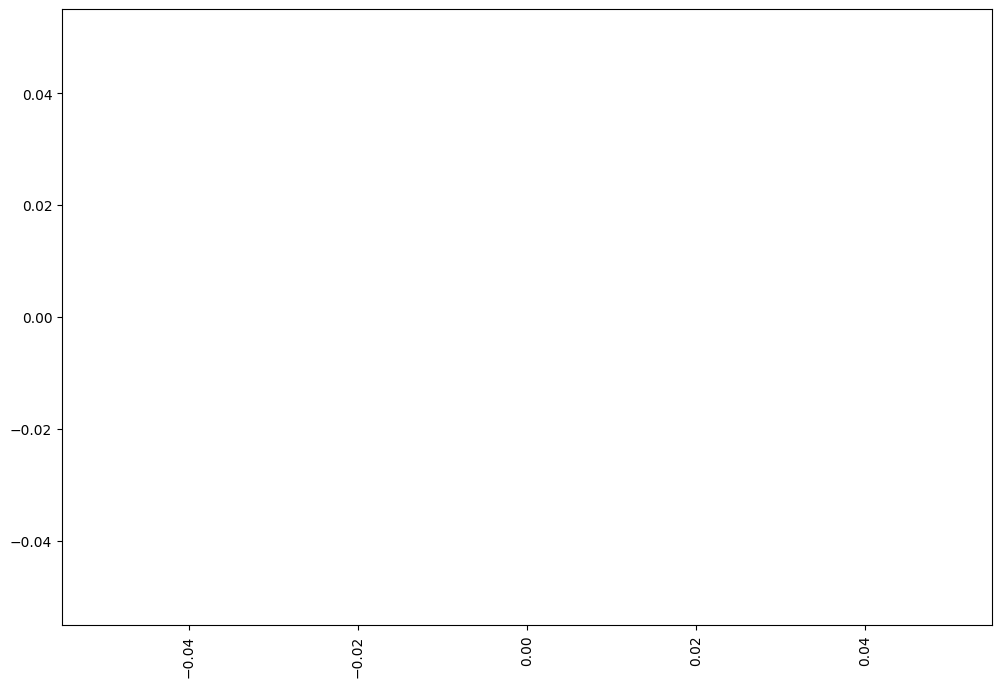

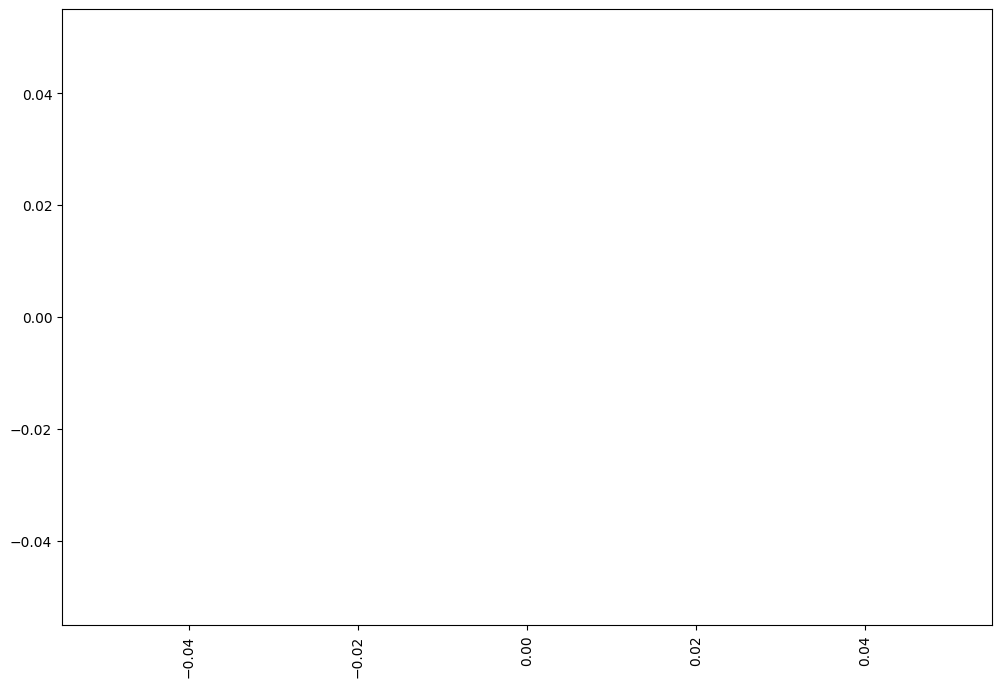

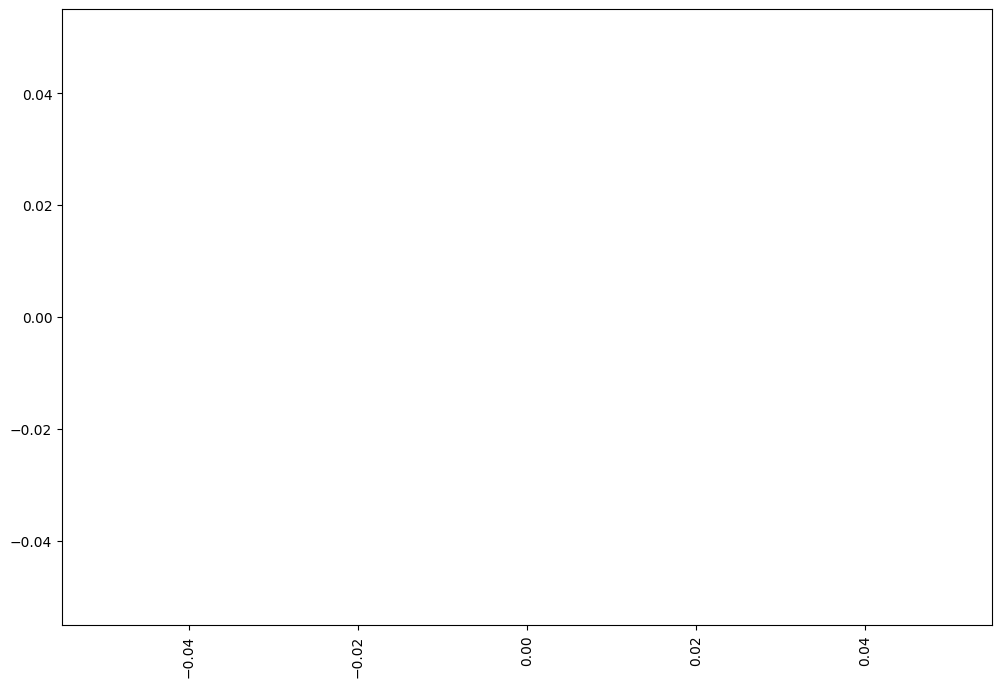

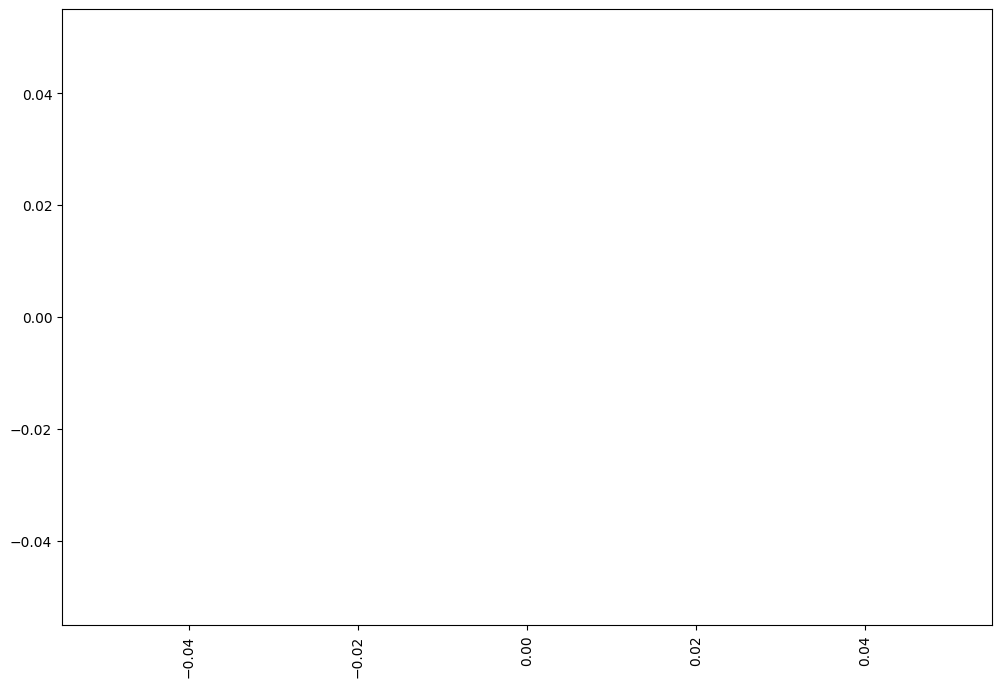

In [9]:
# Hàm lấy dữ liệu đội bóng
def get_team_stats(team, start_year, end_year):
    # Filter matches for the selected team and year range
    matches_home = data[(data['home_team'] == team) & (data['year'] >= start_year) & (data['year'] <= end_year)]
    matches_away = data[(data['away_team'] == team) & (data['year'] >= start_year) & (data['year'] <= end_year)]
    
    # Giữ các cột cần thiết
    necessary_columns = ['year', 'home_team', 'away_team', 'score', 'stat']
    matches_home = matches_home[necessary_columns]
    matches_away = matches_away[necessary_columns]

    # Extract relevant stats for home matches
    def extract_stat_home(stat, index):
        try:
            return ast.literal_eval(stat)[index].split()[0]
        except (IndexError, ValueError):
            return None
    
    # Extract relevant stats for away matches
    def extract_stat_away(stat, index):
        try:
            return ast.literal_eval(stat)[index].split()[1]
        except (IndexError, ValueError):
            return None

    matches_home['total_shots'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 1))
    matches_home['shots_off_target'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 2))
    matches_home['shots_saved'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 3))
    matches_home['corners'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 4))
    matches_home['free_kicks'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 5))
    matches_home['fouls'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 6))
    matches_home['offsides'] = matches_home['stat'].apply(lambda x: extract_stat_home(x, 7))
    
    matches_away['total_shots'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 1))
    matches_away['shots_off_target'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 2))
    matches_away['shots_saved'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 3))
    matches_away['corners'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 4))
    matches_away['free_kicks'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 5))
    matches_away['fouls'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 6))
    matches_away['offsides'] = matches_away['stat'].apply(lambda x: extract_stat_away(x, 7))
    
    # Combine home and away stats
    matches = pd.concat([matches_home, matches_away])
    
    return matches

# Hàm chuẩn hóa dữ liệu
def normalize_series(value, min_val, max_val):
    min_ratio = 0.9
    max_ratio = 1.1
    return (value - min_val * min_ratio) / (max_val * max_ratio - min_val * min_ratio)

# Thay đổi mã chuẩn hóa
def plot_normalized_radar_chart(team, start_year, end_year):
    team_stats = get_team_stats(team, start_year, end_year)
    average_stats = team_stats[['total_shots', 'shots_off_target', 'shots_saved', 'corners', 'free_kicks', 'fouls', 'offsides']].astype(float).mean()
    
    # Calculate goals per match
    goals_home = team_stats[team_stats['home_team'] == team]['score'].apply(lambda x: int(x.split(':')[0])).groupby(team_stats['year']).sum()
    goals_away = team_stats[team_stats['away_team'] == team]['score'].apply(lambda x: int(x.split(':')[1])).groupby(team_stats['year']).sum()
    goals_per_year = goals_home.add(goals_away, fill_value=0)
    total_matches_per_year = team_stats['year'].value_counts().sort_index()
    goals_per_match_per_year = goals_per_year / total_matches_per_year
    average_goals_per_match = goals_per_match_per_year.mean()
    
    # Add goals per match to the radar chart
    average_stats['goals_per_match'] = average_goals_per_match
    
    # Đọc giá trị từ file CSV
    with open('data_raw/team_stats_results.csv', mode='r') as file:
        reader = csv.DictReader(file)
        max_values = {}
        min_values = {}
        for row in reader:
            max_values[row['']] = float(row['Highest Values'])
            min_values[row['']] = float(row['Lowest Values'])

    # Chuẩn hóa giá trị của từng chỉ số trong average_stats
    normalized_stats = pd.Series({
        stat: normalize_series(average_stats[stat], min_values[stat], max_values[stat])
        for stat in average_stats.index
    })

    labels = normalized_stats.index
    values = normalized_stats.values

    # Number of variables
    num_vars = len(labels)

    # Compute angle for each axis to form a polygon
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart is circular, so we need to "complete the loop" and append the start value to the end.
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    # Draw the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=1)

    # Set the labels for each axis
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Add a title
    plt.title(f'Normalized Average Stats per Match by {team} from {start_year} to {end_year}', size=20, color='blue', y=1.1)

    plt.show()

# Tạo widget dropdown
team_selector = widgets.Dropdown(
    options=sorted(all_teams),
    description='Select Team:'
)

start_year_selector = widgets.Dropdown(
    options=sorted(data['year'].unique()),
    description='Start Year:'
)

end_year_selector = widgets.Dropdown(
    options=sorted(data['year'].unique()),
    description='End Year:'
)

# Hàm cập nhật biểu đồ khi chọn đội bóng và năm
def update_performance_analysis(team, start_year, end_year):
    plot_normalized_radar_chart(team, start_year, end_year)

# Display the dropdown menu and set up the event handler
widgets.interactive(update_performance_analysis, team=team_selector, start_year=start_year_selector, end_year=end_year_selector)


interactive(children=(Dropdown(description='Select Team:', options=('AFC Bournemouth', 'Arsenal FC', 'Aston Vi…

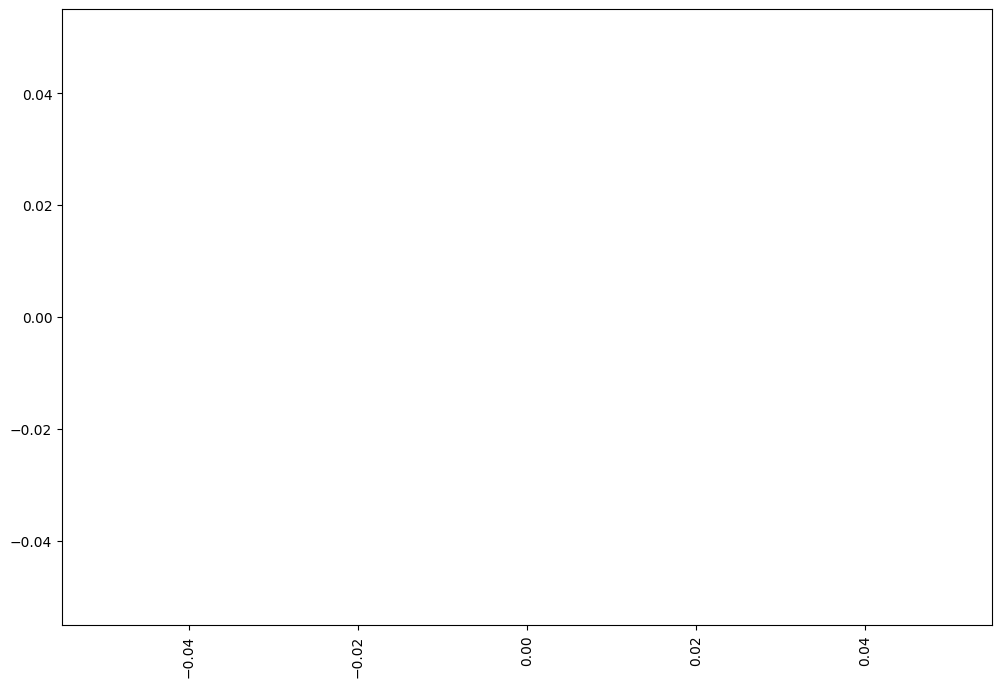

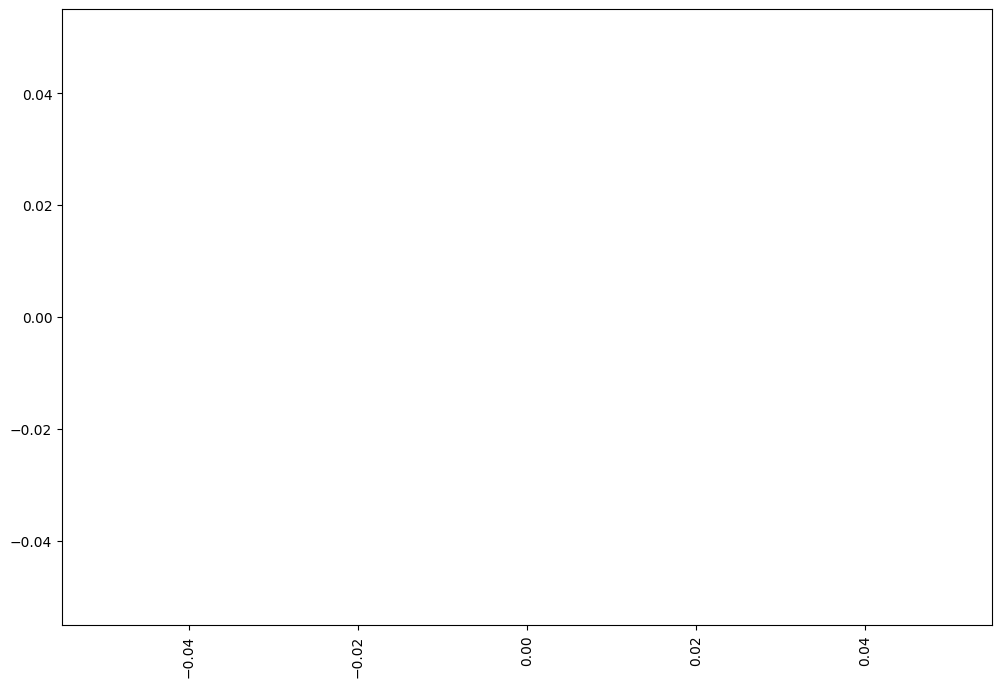

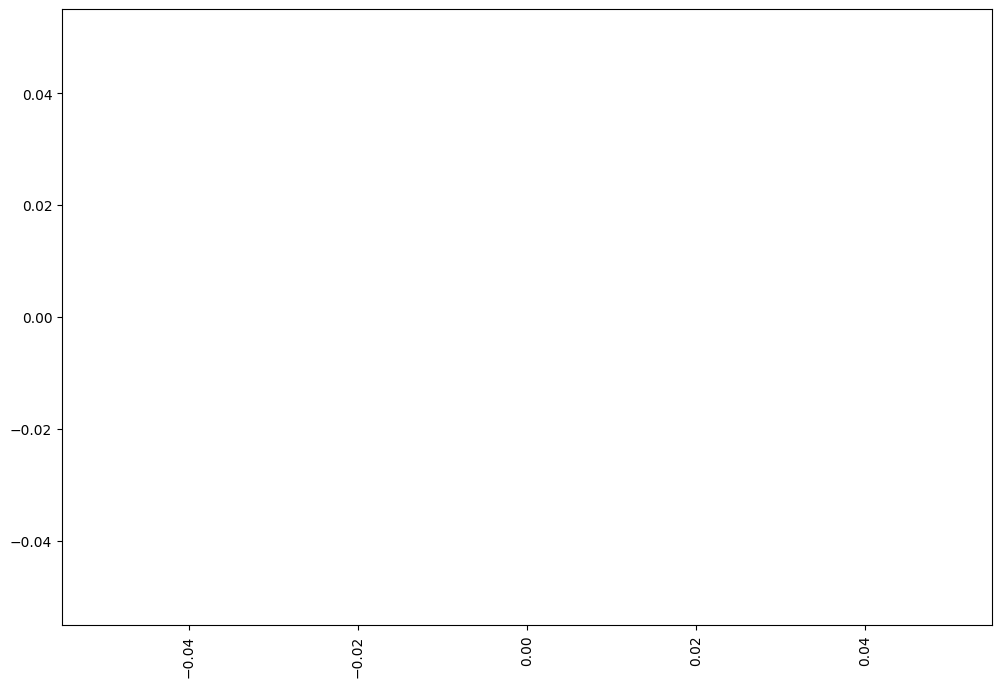

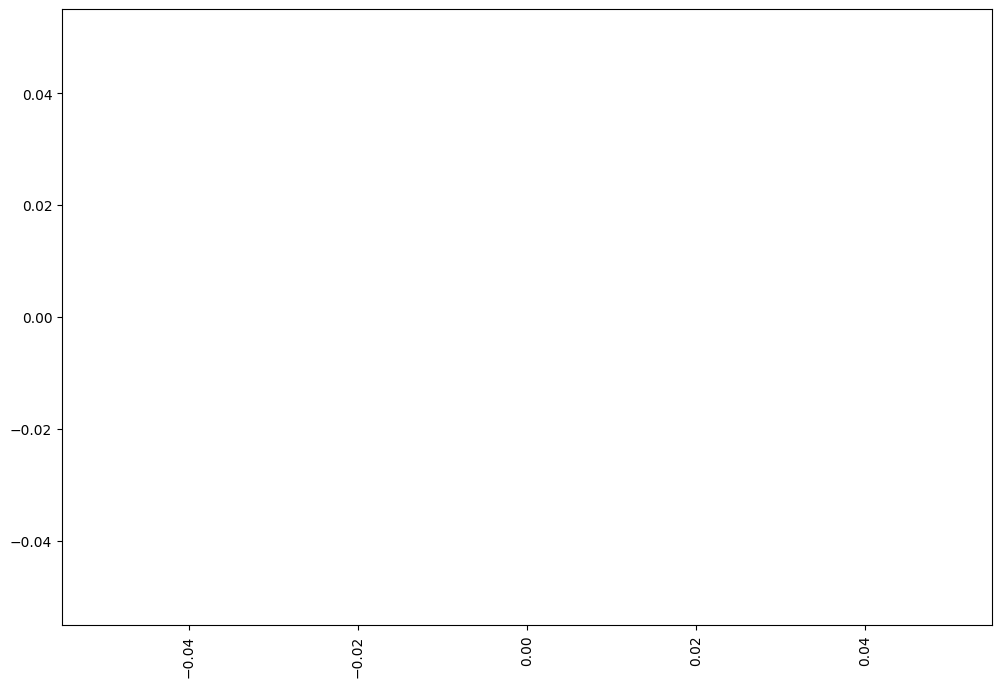

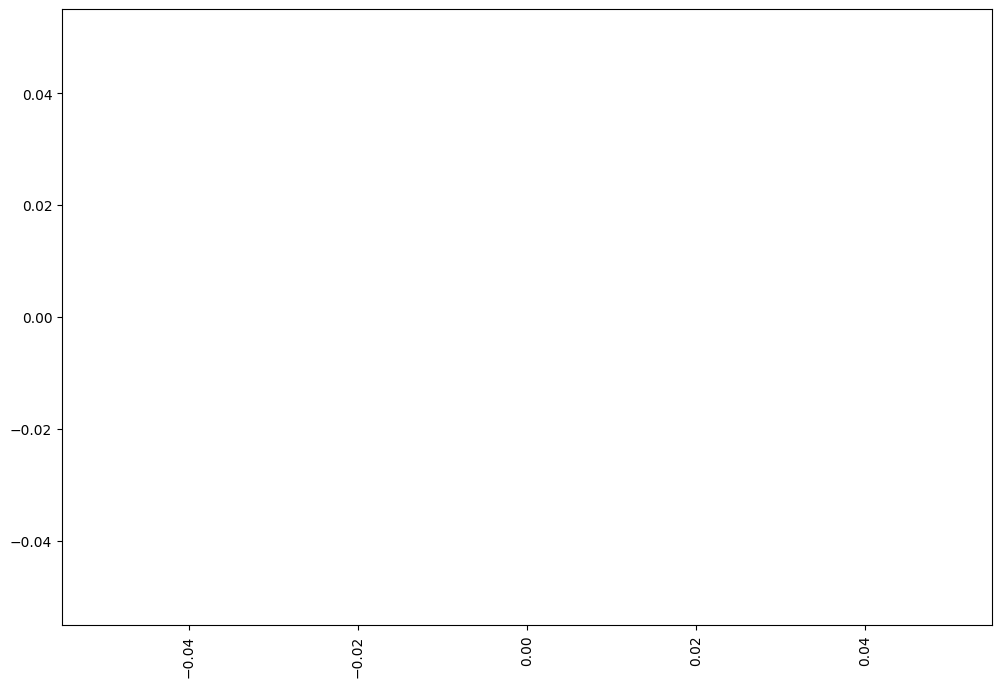

In [10]:
# Function to update the plot based on selected team and year range
def update_goal_analysis(team, start_year, end_year):
    # Filter matches for the selected team and year range
    matches_home = data[(data['home_team'] == team) & (data['year'] >= start_year) & (data['year'] <= end_year)]
    matches_away = data[(data['away_team'] == team) & (data['year'] >= start_year) & (data['year'] <= end_year)]
    
    # Combine home and away matches
    matches = pd.concat([matches_home, matches_away])
    
    # Extract goals and time from home and away goals
    goals_home = matches['home_goals'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
    goals_away = matches['away_goals'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
    
    # Flatten the list of goals and create a DataFrame
    goals = []
    for goal_list in goals_home:
        goals.extend(goal_list)
    for goal_list in goals_away:
        goals.extend(goal_list)
    
    goal_df = pd.DataFrame(goals, columns=['Time', 'Description'])
    goal_df['Time'] = goal_df['Time'].astype(int)
    
    # Group by 10-minute intervals to count the number of goals
    goal_df['Time Interval'] = (goal_df['Time'] // 10) * 10
    goal_counts = goal_df.groupby('Time Interval').size()
    
    # Plot goals scored over time as a bar chart
    plt.figure(figsize=(12, 8))
    goal_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Goals Scored Over Time by {team} from {start_year} to {end_year}')
    plt.xlabel('Time Interval (minutes)')
    plt.ylabel('Number of Goals')
    plt.xticks(rotation=45)
    plt.show()

# Display the dropdown menus and set up the event handler
widgets.interactive(update_goal_analysis, team=team_selector, start_year=start_year_selector, end_year=end_year_selector)
